In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

In [13]:
# train_dir = "dataset/train/0"
# test_dir = "dataset/test/0"
# for file in os.listdir(train_dir):
#     finger_num = file[-6:-5]
#     if finger_num in ["1", "3", "4"]:
#         os.remove(os.path.join(train_dir, file))

In [4]:
train_dir = "dataset/train"
test_dir = "dataset/test"

train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=32, color_mode="grayscale" ,class_mode="input", target_size=(64, 64))
test_generator = train_datagen.flow_from_directory(test_dir, batch_size=32, color_mode="grayscale" ,class_mode="input", target_size=(64, 64))

train_num = train_generator.n
test_num = train_generator.n

Found 9000 images belonging to 1 classes.
Found 3600 images belonging to 1 classes.


In [5]:
it = iter(train_generator[0][0])

(64, 64, 1)


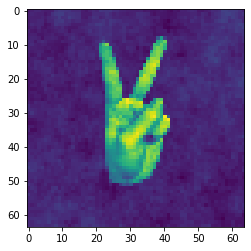

In [6]:
img = next(it)
print(img.shape)
plt.imshow(img)
plt.show()

In [7]:
from utils.models import create_vae_model
from utils.losses import reconstruction_loss
from utils.callbacks import SaveDecoderOutput, SaveDecoderModel

In [17]:
log_dirs = 'logs/fingers_4'
model_dir = log_dirs + '/models'
os.makedirs(model_dir, exist_ok=True)
model_tb = keras.callbacks.TensorBoard(log_dir=log_dirs)
model_sdw = SaveDecoderModel(model_dir + '/best_model.h5', monitor='val_loss')
model_testd = SaveDecoderOutput(64, log_dir=log_dirs)

In [18]:
# create vae model
input_shape = (64, 64, 1)
latent_dim = 2
vae_model = create_vae_model(input_shape, latent_dim)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 64, 64, 64)   640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 128)  73856       conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 16, 16, 128)  147584      conv2d_13[0][0]                  
____________________________________________________________________________________________

In [19]:
# training
optimizer = tf.keras.optimizers.RMSprop()
vae_model.compile(optimizer, loss=reconstruction_loss)
# vae_model.fit(train_data, epochs=100, validation_data=test_data, callbacks=[model_tb, model_sdw, model_testd])
batch_size = 128
epochs = 100
steps_per_epoch = int(train_num / batch_size)

In [20]:
trainHistory = vae_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[model_tb, model_sdw, model_testd]
)

Epoch 1/100
70/70 [==============================] - 9s 101ms/step - loss: 78012.2344 - val_loss: 2191.0757
Epoch 2/100
70/70 [==============================] - 6s 89ms/step - loss: 2168.8386 - val_loss: 2165.2422
Epoch 3/100
70/70 [==============================] - 6s 88ms/step - loss: 2162.8884 - val_loss: 2165.2493
Epoch 4/100
70/70 [==============================] - 6s 90ms/step - loss: 2149.9624 - val_loss: 2147.2139
Epoch 5/100
70/70 [==============================] - 6s 89ms/step - loss: 2129.7747 - val_loss: 2146.9238
Epoch 6/100
70/70 [==============================] - 6s 89ms/step - loss: 2126.7590 - val_loss: 2152.0854
Epoch 7/100
70/70 [==============================] - 6s 89ms/step - loss: 2124.3496 - val_loss: 2150.0601
Epoch 8/100
70/70 [==============================] - 6s 91ms/step - loss: 2124.4109 - val_loss: 2147.4912
Epoch 9/100
70/70 [==============================] - 6s 89ms/step - loss: 2116.6602 - val_loss: 2148.2131
Epoch 10/100
70/70 [========================

In [21]:
best_model = load_model("logs/fingers_4/models/best_model.h5")

In [26]:
def imshow(img):
    if img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    plt.imshow(img)
    plt.show()

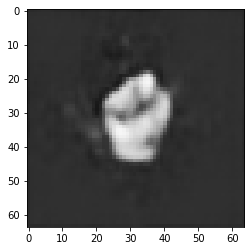

In [27]:
vector = (5, 5)
predicts = best_model.predict([vector])
img = predicts[0]
imshow(img)

In [29]:
n = 10
rate = 2
grid_x = np.linspace(-rate, rate, n)
grid_y = np.linspace(-rate, rate, n)
size = 64
draw = np.zeros((size * n, size * n, 3))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        img = best_model.predict(z_sample)[0]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        draw[i * size: (i + 1) * size, j * size: (j + 1) * size] = img

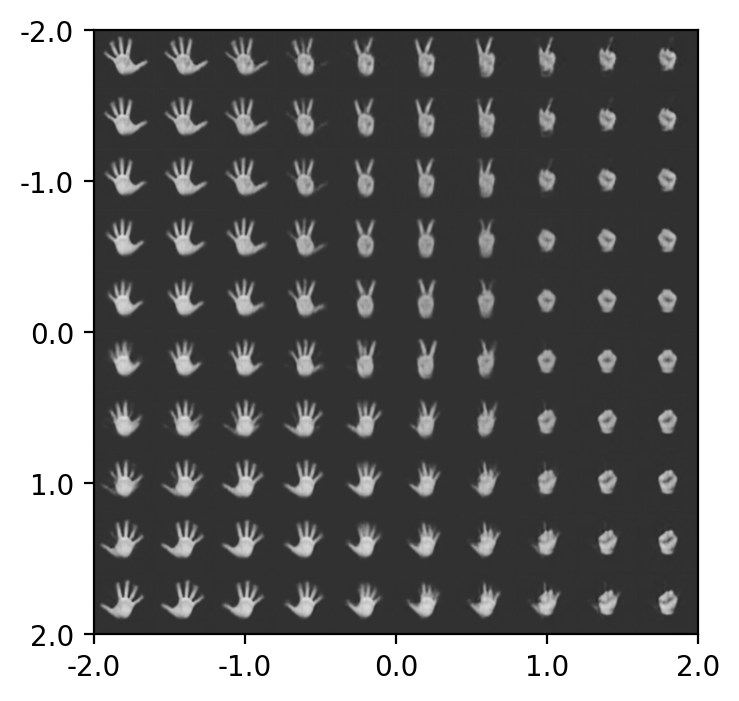

In [30]:
plt.figure(dpi=200)
plt.imshow(draw)
plt.xticks(np.linspace(0, size * n, 5), np.linspace(-rate, rate, 5))
plt.yticks(np.linspace(0, size * n, 5), np.linspace(-rate, rate, 5))
plt.show()

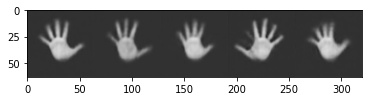

In [84]:
x = np.random.normal(-2, 0.8, 5)
y = np.random.normal(0, 0.8, 5)
z = np.column_stack((x, y))
draw = np.zeros((size, size * 5, 3))
for i, xi in enumerate(z):
    img = best_model.predict(xi[np.newaxis, :])[0]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    draw[0: size, i * size: (i + 1) * size] = img
imshow(draw)

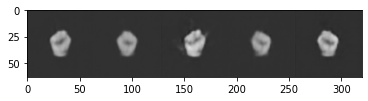

In [79]:
x = np.random.normal(0.3, 0.8, 5)
y = np.random.normal(0, 2, 5)
z = np.column_stack((x, y))
draw = np.zeros((size, size * 5, 3))
for i, xi in enumerate(z):
    img = best_model.predict(xi[np.newaxis, :])[0]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    draw[0: size, i * size: (i + 1) * size] = img
plt.imshow(draw)
plt.show()

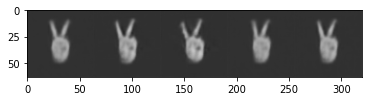

In [85]:
x = np.random.normal(0, 0.5, 5)
y = np.random.normal(-1.5, 0.5, 5)
z = np.column_stack((x, y))
draw = np.zeros((size, size * 5, 3))
for i, xi in enumerate(z):
    img = best_model.predict(xi[np.newaxis, :])[0]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    draw[0: size, i * size: (i + 1) * size] = img
plt.imshow(draw)
plt.show()

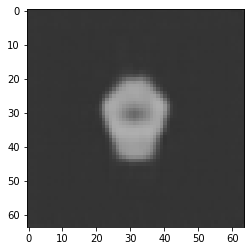

In [21]:
vector = (0, 1)
predicts = best_model.predict([vector])
img = predicts[0]
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.imshow(img)
plt.show()